In [1]:
import pandas as pd
import numpy as np
import shap
from floridaman import data_cleaning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
# load in data
raw_data = data_cleaning.load('null_transformed')

In [3]:
full_data = data_cleaning.drop_columns(raw_data, .4, .4)
balanced_data = data_cleaning.balance(full_data)

full_data = data_cleaning.impute_values(full_data, 5)
balanced_data = data_cleaning.impute_values(balanced_data, 5)


X_train = np.array(tempX)
y_train = np.array(balanced_data['FAILURETYPE'])

X_test = np.array(tempX_test)
y_test = np.array(full_data['FAILURETYPE'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Optimize Random Forest through Random Search

In [4]:
# Specify hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [5]:
# Create the hyperparameter grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [6]:
# Create a basic RF classifier
rf_model = RandomForestClassifier()

# Create grid search object with specified parameter grid. Perform 
# cross validation with 8 folds to randomly select combinations of hyperparameters 
# from random_grid and return the combination that performs the best.
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 8, verbose = 2, n_jobs = -1)
# LOL n_jobs = 12 for the 14 core machine - please change this to something reasonable like 4

# Fit classifier to X_train and y_train
rf_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 4320 candidates, totalling 34560 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 5544 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 7652 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 10080 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12836 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15912 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 19316 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 23040 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 27092 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 31464 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 34560 out of 34560 | elapsed:  3.9min finished


GridSearchCV(cv=8, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 4, 5, 6, 6, 7, 8, 8, 9, 10]},
             verbose=2)

In [7]:
# Create better model with tuned hyperparameters
best_model = rf_grid.best_estimator_

### Random Forest Results

In [8]:
print(str(classification_report(y_test, best_model.predict(X_test))))
print("")
print("Classifier training score: " + str(best_model.score(X_train, y_train)))
print("Best combination of hyperparameters: ")
rf_grid.best_params_ # prints the best combination of hyperparameters for our data set 

                 precision    recall  f1-score   support

           Rods       0.30      0.72      0.42       207
Sucker Rod Pump       0.68      0.62      0.65       590
         Tubing       0.76      0.55      0.64       874

       accuracy                           0.60      1671
      macro avg       0.58      0.63      0.57      1671
   weighted avg       0.68      0.60      0.62      1671


Classifier training score: 0.8518518518518519
Best combination of hyperparameters: 


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 9}

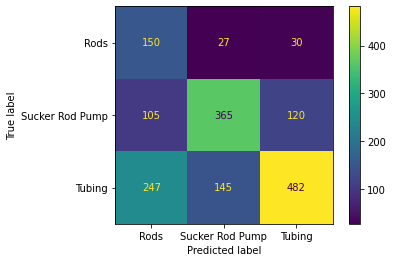

In [9]:
# Plot the confusion matrix
cm = plot_confusion_matrix(best_model, X_test, y_test)

# SHAP 

In [10]:
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.initjs()

#### class # as we encoded it:
- Rods = 0
- SRP = 1
- Tubing = 2

### Summary for all features and all classes (including Noise)

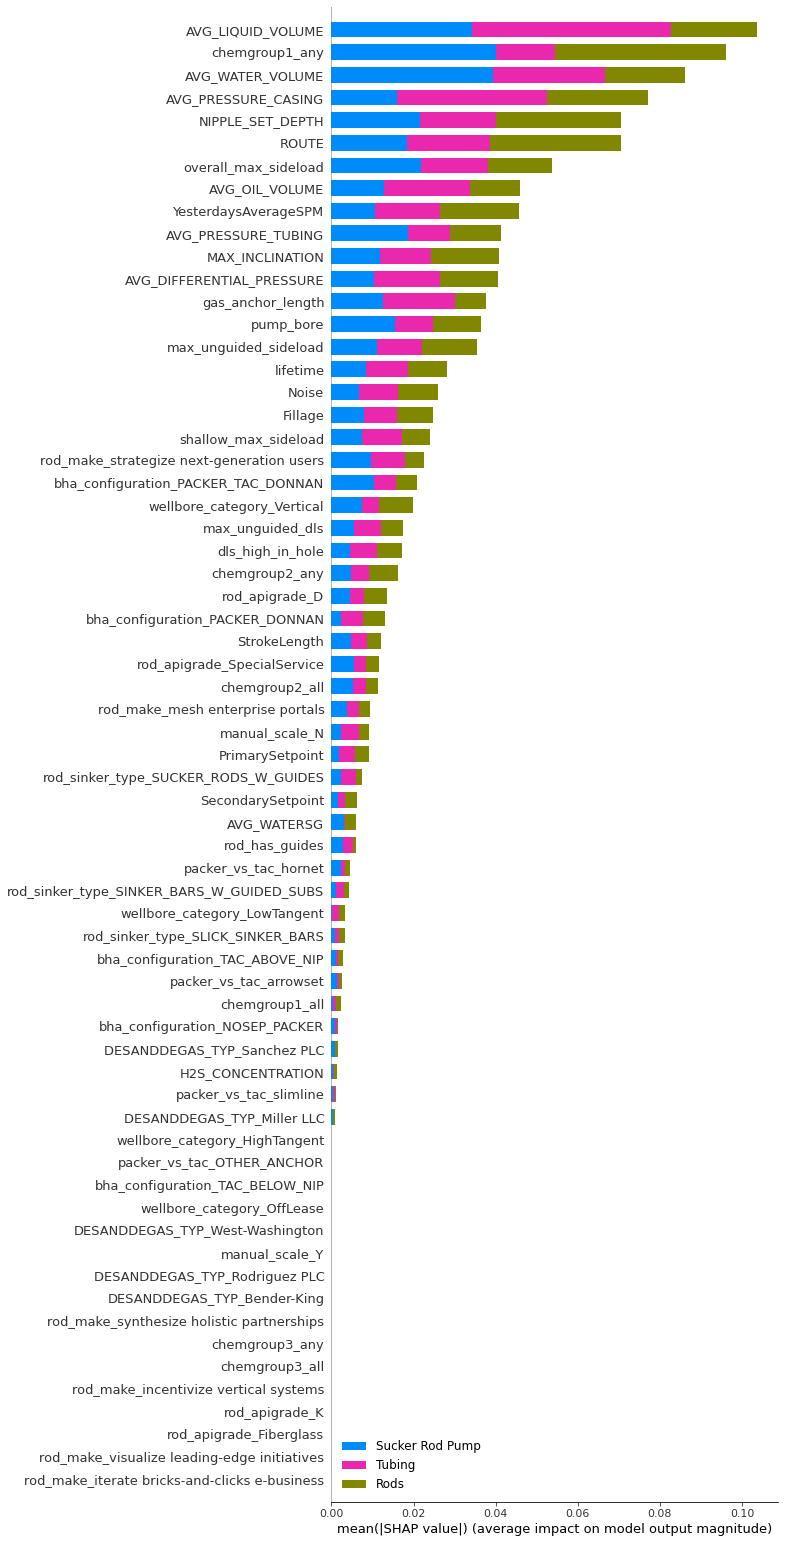

In [11]:
shap.summary_plot(shap_values, 
                  X_test, 
                  max_display = 65, # only displays 40 features
                  feature_names = data_cleaning.features(tempX), 
                  class_names = ['Rods', 'Sucker Rod Pump', 'Tubing'], 
                  show=False)
#plt.savefig('summaryPlot.png')

shap.save_html('RandomShapSRP.html',
               shap.force_plot(explainer.expected_value[1], 
                               shap_values[1], X_test, 
                               feature_names = data_cleaning.features(balanced_data),
                              matplotlib=False))

shap.save_html('RandomShapRods.html',
               shap.force_plot(explainer.expected_value[0], 
                               shap_values[1], X_test, 
                               feature_names = data_cleaning.features(balanced_data),
                               matplotlib=False))

shap.save_html('RandomShapTubing.html',
               shap.force_plot(explainer.expected_value[2], 
                               shap_values[1], X_test, 
                               feature_names = data_cleaning.features(balanced_data),
                               matplotlib=False))